In [4]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import make_interpolation, ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct

import torchvision.models as models
from torch.autograd import Variable

import scipy.stats as stats

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))


In [24]:
# https://github.com/PAIR-code/saliency/blob/master/Examples_pytorch.ipynb

import saliency.core as saliency

# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im)
    plt.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

transformer = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean = IMAGENET_MEAN, std = IMAGENET_STD),
])

def LoadNumpy(file_path):
    im = Image.open(file_path)
    im = im.resize((224, 224)) # reserve channel 
    im = np.asarray(im)
    return im    

# def PreprocessImages(images):
#     # assumes input is 4-D, with range [0,255]
#     #
#     # torchvision have color channel as first dimension
#     # with normalization relative to mean/std of ImageNet:
#     #    https://pytorch.org/vision/stable/models.html
#     images = np.array(images)
#     images = images/255
#     images = np.transpose(images, (0,3,1,2))
#     images = torch.tensor(images, dtype=torch.float32)
#     images = transformer.forward(images)
#     return images.requires_grad_(True)

def LoadTensor(file_path):
    im = Image.open(file_path)
    temp = np.asarray(im)
#     if len(temp.shape) == 3: images = transformer(im)    
#     else: return None
    
    images = transformer(im)    
    return images.requires_grad_(True)

In [6]:
# model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
# eval_mode = model.eval()

model = models.resnet18(pretrained=False)
save_path = f'/root/pretrained/imagenet_val.pth'
model.load_state_dict(torch.load(save_path))
eval_mode = model.eval()


/root/dh/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/dh/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [120]:
# n02443484: 40 black-footed_ferret
# n01614925: 398 bald_eagle

data_path="/root/data/ILSVRC2012_val/"

ferrot_dir = os.path.join(data_path, 'val', 'n02443484')
ferrot_idx = os.listdir(ferrot_dir)[1]
ferrot_np = LoadNumpy(os.path.join(ferrot_dir, ferrot_idx))
ferrot_tensor = LoadTensor(os.path.join(ferrot_dir, ferrot_idx))

eagle_dir = os.path.join(data_path, 'val', 'n01614925')
eagle_idx = os.listdir(eagle_dir)[1]
eagle_img = LoadNumpy(os.path.join(eagle_dir, eagle_idx))
eagle_tensor = LoadTensor(os.path.join(eagle_dir, eagle_idx))


In [12]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs

In [6]:
predictions = eval_mode(ferrot_tensor.unsqueeze(0))
predictions = predictions.detach().numpy()
prediction_class = np.argmax(predictions[0])
# call_model_args = {class_idx_str: prediction_class}

# print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 236
# im = ferrot_img.astype(np.float32)
print(prediction_class)

358


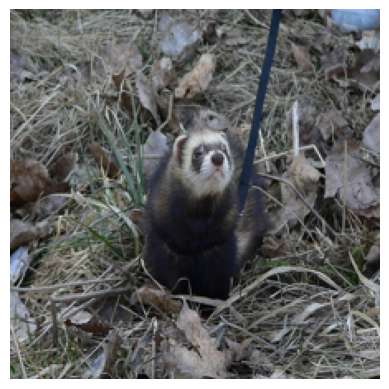

In [10]:
ShowImage(ferrot_np)

In [38]:
ferrot_dir = os.path.join(data_path, 'val', 'n02443484')
ferrot_list = os.listdir(ferrot_dir)
ferrot_list = [file for file in ferrot_list if file.endswith(".JPEG")]
m = 0

for i in range(len(ferrot_list)):
#     print(ferrot_list[i])
    path = os.path.join(ferrot_dir, ferrot_list[i])
    img = LoadTensor(path) 
    img = img.unsqueeze(0)
#     if img:
    score = eval_mode(img)
    idx = torch.argmax(score, dim = -1)
    
    if idx.item() == 359:
        if m == 0:
#             print(1)
            ferrot = img#.unsqueeze(0)
        else: 
#             print(2)
            ferrot = torch.vstack((ferrot, img))
        m = m + 1
#         print(m)

#     print(img.shape, ferrot.shape)
print(ferrot.shape)    


torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([2, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([3, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([4, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([5, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([6, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([7, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([8, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([9, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([10, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([11, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([12, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([13, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([14, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([15, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([16, 3, 224, 224])
torch.S

In [39]:
# ferrot.shape
score = eval_mode(ferrot)
# print(score.shape)
idx = torch.argmax(score, dim = -1)
idx
# print(idx.shape)
# ferrot_tensor
# img.shape

tensor([359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359,
        359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359,
        359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359,
        359, 359, 359])

In [154]:
# for image
# import scipy.stats as stats

def get_rank(attribution, k):
    flat = attribution.flatten()
    num = int(attribution.size(-1) * k / 100)
    val, idx = torch.topk(flat, num)
    idx_list = [[x.item() // 224, x.item() % 224] for x in idx]
    return idx_list
    
def delete_attribution(tensor, attribution, k, device):
    idx = get_rank(attribution, k)
#     print(len(idx))
    temp = tensor.clone().detach()
    for i in idx:
        j, k = i
        temp[:, j, k] = -1000 # convert to image: Normalize
    temp = temp.to(device)
    return temp

def kendal_tau(tensor, attrib):    
    temp = tensor.mean(dim = 0)
    temp1 = temp.flatten().detach().cpu().numpy()
    temp2 = attri.flatten().detach().cpu().numpy()
    val, p_val = stats.kendalltau(temp1, temp2)
    return val
    
    
def pipeline(model, tensor, baseline, attr, k, device, name):    
    model = model.to(device)
    logit_orig = model(tensor.unsqueeze(0))
    score_orig = nn.functional.softmax(logit_orig, dim = -1)
    init_pred = torch.argmax(logit_orig).item()
    prob_orig = score_orig[0, init_pred].item()
#     if attr: pass
#     else: attr = ig(model.to(device), tensor.to(device), init_pred, baseline, device)
    
    new_tensor = delete_attribution(tensor, attr, k, device)
    logit_new = model(new_tensor.unsqueeze(0))
    score_new = nn.functional.softmax(logit_new, dim = -1)
    prob_new = score_new[0, init_pred].item()
    
#     if name == "aopc":
#         metric = prob_orig - prob_new
#     elif name == "lodds":
#         metric = np.log(prob_new / prob_orig)
#     elif name == "kendal":
    metric_aopc = prob_orig - prob_new
    metric_lodds = np.log(prob_new / (prob_orig + 1e-5))        
#     metric_kendall = 
    return metric_aopc, metric_lodds
    
    

    

4.108103e-07 0.24180862 0.005363762


(array([4.7999e+04, 1.5020e+03, 4.2800e+02, 1.5700e+02, 5.4000e+01,
        2.3000e+01, 8.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([4.10810287e-07, 2.41812319e-02, 4.83620539e-02, 7.25428760e-02,
        9.67236981e-02, 1.20904520e-01, 1.45085335e-01, 1.69266164e-01,
        1.93446979e-01, 2.17627808e-01, 2.41808623e-01]),
 <BarContainer object of 10 artists>)

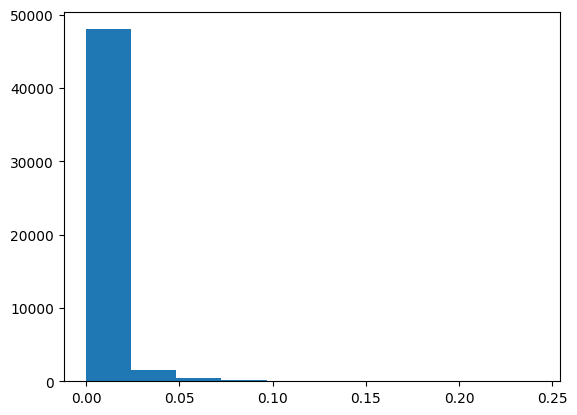

In [138]:
from sklearn import preprocessing as pre

# ferrot_tensor.mean()
# import scipy.stats as stats
# temp = ferrot_tensor.mean(dim = 0)
# temp1 = temp.flatten().detach().cpu().numpy()
# temp2 = attri.flatten().detach().cpu().numpy()
# u, j = stats.kendalltau(temp1, temp2)
# print(u)
# print(temp1.min(), temp1.max(), temp1.mean())
# print(temp2.min(), temp2.max(), temp2.mean())
# norm1 = pre.MinMaxScaler().fit_transform(temp1.reshape(-1, 1))
# norm2 = pre.MinMaxScaler().fit_transform(temp2.reshape(-1, 1))
# stats.kendalltau(norm1, norm2)

# plt.hist(temp2)

eval_mode()

0
tensor(359, device='cuda:0')
torch.Size([3, 224, 224])


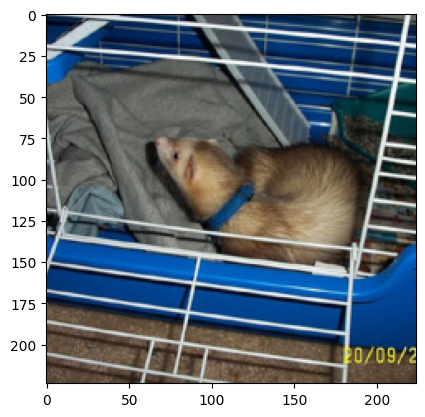

In [110]:
t = delete_attribution(ferrot_tensor, attri, 0, 'cuda:0')
# t.shape
print(torch.argmax(eval_mode(t.unsqueeze(0))))
print(t.shape)
plt.imshow(convert_to_img(t))


tensor([[[0., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[0., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[0., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]])

In [139]:
# int(5 * ferrot_tensor.size(-1) / 100)
# torch.argmax(eval_mode(ferrot_tensor.unsqueeze(0)))
# a = get_rank(attri.cpu(), 1)
# i, j = a[0]
# i

# attri.shape
# temp = ferrot_tensor.clone().detach()
# temp[:, 95, 142] = 0
# torch.argmax(eval_mode(temp.unsqueeze(0).to('cuda:0')))
logit = eval_mode(ferrot_tensor.unsqueeze(0).to('cuda:0'))
# score = nn.functional.softmax(logit, dim = -1)
# score[0, 359]
print(torch.argmax(logit), torch.argmin(logit))

tensor(359, device='cuda:0') tensor(663, device='cuda:0')


In [45]:
baseline = torch.zeros_like(ferrot_tensor)

attri = ig(eval_mode.to('cuda:0'), ferrot_tensor, 359, baseline, device='cuda:0', M=25)



In [59]:
# attri.shape # 224x224
# attrib = attri.flatten()
# attrib.shape # 50176
val, idx = torch.topk(attrib.cpu(), 10)
idx_list = [[x.item() // 224, x.item() % 224] for x in idx]
# print(idx_list
for i, j in enumerate(idx):
    print(j, j//224, j%224, idx_list[i])

tensor(21422) tensor(95) tensor(142) [95, 142]
tensor(24988) tensor(111) tensor(124) [111, 124]
tensor(25011) tensor(111) tensor(147) [111, 147]
tensor(26743) tensor(119) tensor(87) [119, 87]
tensor(21604) tensor(96) tensor(100) [96, 100]
tensor(17759) tensor(79) tensor(63) [79, 63]
tensor(17853) tensor(79) tensor(157) [79, 157]
tensor(18773) tensor(83) tensor(181) [83, 181]
tensor(15990) tensor(71) tensor(86) [71, 86]
tensor(21828) tensor(97) tensor(100) [97, 100]


gaussian_blur
maximumdistance


/tmp/ipykernel_263/855788135.py:49: RuntimeWarning: divide by zero encountered in log
  metric_lodds = np.log(prob_new / (prob_orig + 1e-5))


scalar
max
one
uniform
zero
min
gaussian


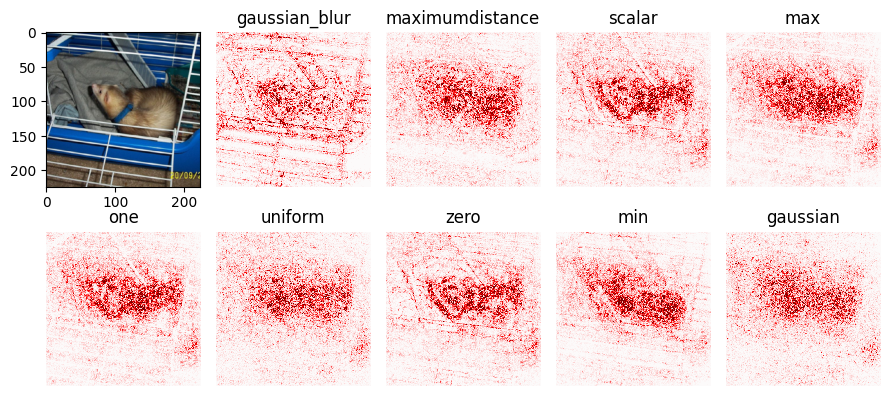

In [170]:
device = 'cuda:0'
names = {
    'zero',
    'one',
    'min',
    'max',
    'scalar',
#     'encoder',
#     'optimizer',
#     'hybrid',
    'gaussian_blur',
    'gaussian',
    'uniform',
    'maximumdistance' 
}

index = 0 
# x,y = valid_datasets[index]
x = ferrot_tensor
y = 359

fig, axes = plt.subplots(2, (len(names)//2)+1, figsize=(2*len(names)//2, 2*2))
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

ax = next(axes_flat)
ax.imshow(convert_to_img(x))

AOPC = []
LODDs = []
for name in names:
    a = []
    b = []
    try:
        b_generator =  get_baseline_generator(name, scalar = 0.3)
        baseline = b_generator(x=x,y=y)

    except Exception as e: 
        print("-----")
        print("fail:", name)
        print(e)
        continue
        
    attr = ig(eval_mode.to(device), x, y, baseline, device=device)
    print(name)
    for i in range(19):
        k = i * 5 + 5        
        aopc, lodds = pipeline(eval_mode, ferrot_tensor.to(device), baseline, attr, k, device, name)
#         print(name, k, aopc, lodds)
        a.append(aopc)
        b.append(lodds)
    
    attr, kwargs  = process_heatmap(attr.cpu(), my_cmap)
    ax = next(axes_flat)
    ax.imshow(attr, **kwargs)
    ax.set_title(name)
    ax.axis("off")
    
    AOPC.append(a)
    LODDs.append(b)    
    
plt.tight_layout()

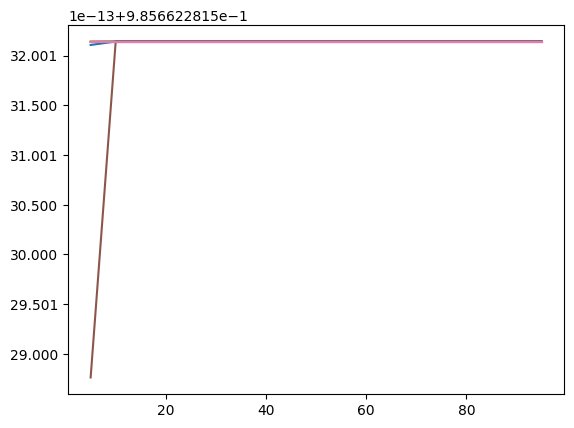

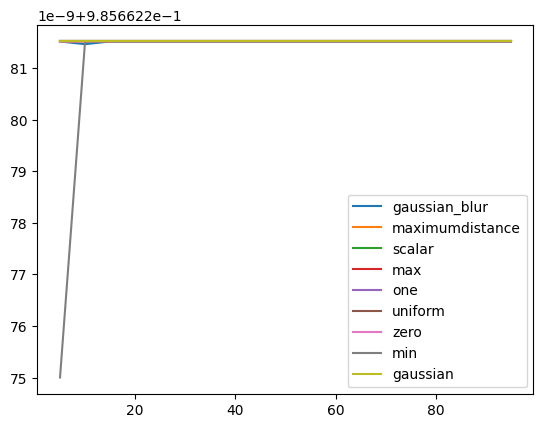

In [175]:
plt.figure()

k = np.arange(19)
k = k * 5 + 5
plt.plot(k, AOPC[0])
plt.plot(k, AOPC[1])
plt.plot(k, AOPC[2])
plt.plot(k, AOPC[3])
plt.plot(k, AOPC[4])
plt.plot(k, AOPC[5])
plt.plot(k, AOPC[6])
plt.plot(k, AOPC[7])
plt.plot(k, AOPC[8])
# print(k)

plt.figure()
# for i in range(len(AOPC)):    
for i, name in enumerate(names):
    plt.plot(k, AOPC[i], label = name)
    plt.legend()

# plt.plot(k, AOPC[0], l)
#     print(i)

In [169]:
names[]

TypeError: 'set' object is not subscriptable